In [1]:
import numpy as np 
import pandas as pd

In [2]:
df = pd.read_csv("dataset_NN.csv")
df = df.dropna()

In [3]:
def standardize(df):
    out = df.pop('class')
    df = (df - np.mean(df))/np.std(df)
    df['class'] = out
    return df

In [4]:
def genTrainTestSplit(dataframe):
    dataframe = dataframe.sample(frac=1, random_state=42).reset_index(drop=True)
    LEN = len(dataframe)
    trainSplit = dataframe.loc[0:0.7*LEN - 1,:]
    testSplit = dataframe.loc[0.7*LEN:LEN,:]
    trainY = trainSplit.pop('class').to_numpy().reshape((-1,1))
    trainX = trainSplit.to_numpy()
    testY = testSplit.pop('class').to_numpy().reshape((-1,1))
    testX = testSplit.to_numpy()
    return (trainX,trainY,testX,testY)

In [5]:
def makeOutput(outPut):
    LEN = outPut.shape[0]
    res = np.zeros((LEN,10))
    for i in range(LEN):
        res[i][outPut[i]-1] = 1
    return res 

In [6]:
df = standardize(df)
df = df.dropna()

In [7]:
trX,trY,tX,tY = genTrainTestSplit(df)

In [8]:
testY = makeOutput(tY)
trainY = makeOutput(trY)

In [9]:
class Layer:
    def __init__(self):
        self.input = None 
        self.output = None

    def forProp(self,input):
        raise NotImplementedError

    def BackProp(self,outErr,LR):
        raise NotImplementedError

In [10]:
class NormalLayer(Layer):
    def __init__(self,inpsize,outsize):
        self.weights = np.random.rand(inpsize, outsize) - 0.5
        self.bias = np.random.rand(1, outsize) - 0.5

    def forProp(self,inp):
        self.input = inp
        # print(self.input is not None)
        self.output = np.dot(self.input,self.weights) + self.bias
        return self.output
    
    def BackProp(self,outErr,LR):
        inperr = np.dot(outErr, self.weights.T)
        werr  = np.dot(self.input.T,outErr)
        # print("werr shape",werr.shape,self.weights.shape)
        self.weights -= LR*werr
        self.bias -= LR*np.sum(outErr,axis=0).reshape((1,-1))

        return inperr

In [11]:
class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    def forProp(self, inp):
        self.input = inp
        return self.activation(inp)
    
    def BackProp(self, output_error, learning_rate):
        return output_error * self.activation_prime(self.input) 

In [30]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

def relu(x):
    return np.maximum(x, 0)

def relu_prime(x):
    return np.array(x >= 0).astype('int')

def softmax(x):
    num = np.exp(x)
    # print("Num",num)
    den = np.sum(num)
    # print("den",den)
    return x

def softmax_prime(x):
    return np.ones(shape=x.shape)

In [29]:
def mse(y_true, y_pred,isSoftmax=False):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred,isSoftmax = False):
    return 2 * (y_pred - y_true) / y_pred.size


In [14]:
class Network:
    def __init__(self):
        self.layers = []
        self.losses = []
        self.accuracies = []
    def addLayer(self,layer):
        self.layers.append(layer)

    def trainGD(self,X,Y,LR,epochs):
        for i in range(epochs):
            error = 0
            inp = X
            for layer in self.layers:
                inp = layer.forProp(inp)
            error += mse(Y,inp)
            # print(error)
            outErr = mse_prime(Y,inp)
            for layer in reversed(self.layers):
                outErr = layer.BackProp(outErr,LR)
            if i%10 == 0:
                print(error/len(X))
                self.losses.append(error/len(X))
                self.accuracies.append(self.accuracy(X,Y))

    def train(self,X,Y,LR,epochs):
        for i in range(epochs):
            error = 0
            for x, y_true in zip(X, Y):
                inp = x.reshape((1,-1))
                for layer in self.layers:
                    inp = layer.forProp(inp)
                # print(inp.shape)
                outErr = mse_prime(y_true,inp)
                error += mse(y_true, inp)
                # print(mse(y_true,inp))
                # break
                for layer in reversed(self.layers):
                    # print(outErr.shape)
                    outErr = layer.BackProp(outErr,LR)
            if i%10 == 0:
                print(error/len(X))
                self.losses.append(error/len(X))
                self.accuracies.append(self.accuracy(X,Y))
    
    def predict(self,X):
        inp = X
        for layer in self.layers:
            inp = layer.forProp(inp)
        
        return inp 
    
    def accuracy(self,X,Y):
        ratio = sum([np.argmax(y) == np.argmax(self.predict(x)) for x, y in zip(X, Y)]) / len(X)
        return ratio
        

In [35]:
def plot(model,iter,diff):
    import numpy as np 
    import matplotlib.pyplot as plt 
    err = model.losses 
    acc = model.accuracies
    X = np.arange(0,iter,diff)
    plt.plot(X,err)
    plt.show()
    plt.plot(X,acc)
    plt.show()

In [16]:
def run(trainX,trainY,testX,testY,epochs,lr,gd = False):
    layers = [
            NormalLayer(6,30),
            NormalLayer(30,20),
            ActivationLayer(sigmoid,sigmoid_prime),
            NormalLayer(20,10),
            ActivationLayer(relu,relu_prime),
            NormalLayer(10,10),
            ActivationLayer(sigmoid,sigmoid_prime),
            ActivationLayer(softmax,softmax_prime),
        ]
    modelact = Network() 
    modelact.layers = layers
    if gd:
        modelact.trainGD(trainX,trainY,lr,epochs)
    else :
        modelact.train(trainX,trainY,lr,epochs)
    plot(modelact,epochs,10)
    return modelact.accuracy(testX,testY)

0.00021162268889817525
0.0001216216641557808
7.203087613028872e-05
6.502759980469419e-05
6.385737870723198e-05
6.343658583529258e-05
6.316580413653267e-05
6.293260513194332e-05
6.270631098296652e-05
6.247551031401022e-05
6.22292731791206e-05
6.196454094882322e-05
6.167729316168102e-05
6.136781860242574e-05
6.10382643756727e-05
6.068987826648805e-05
6.0325783091968206e-05
5.995311040530724e-05
5.957740334065494e-05
5.9199780464212125e-05
5.882275301328795e-05
5.844793457830981e-05
5.8076948042481485e-05
5.7709015673282793e-05
5.734398900126456e-05
5.698172546151581e-05
5.662196795675791e-05
5.626400877248162e-05
5.5907143431232615e-05
5.555053038718228e-05
5.519352717511227e-05
5.483558648107932e-05
5.4476277293795684e-05
5.411573729577303e-05
5.375439923927195e-05
5.3392876413372694e-05
5.303193170124426e-05
5.267275567865818e-05
5.231656567108032e-05
5.196449400696246e-05


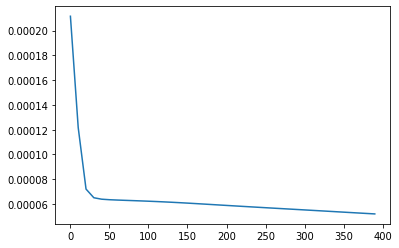

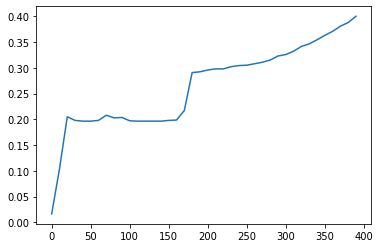

0.4216666666666667

In [17]:
run(trX,trainY,tX,testY,400,1,gd=True)

0.00019676240328886358
6.262602357610272e-05
6.085803702910163e-05
5.893607436052164e-05
5.714280097201288e-05
5.5481424391786876e-05
5.389783332164784e-05
5.2277291957564395e-05
5.0444493742464e-05
4.8276711747113514e-05
4.586249783381198e-05
4.346591297858421e-05
4.1340617231404795e-05
3.960445442132002e-05
3.825871923473249e-05
3.7202191757578844e-05
3.633560267749668e-05
3.558868180985462e-05
3.4915949849528885e-05
3.428629946798441e-05
3.3683559470140526e-05
3.310663499223896e-05
3.255562859497684e-05
3.2034032055661645e-05
3.15424850783711e-05
3.1085570429042704e-05
3.06652769246683e-05
3.0253540914558695e-05
2.989582681638651e-05
2.957451281364781e-05
2.9283440094996362e-05
2.901998684117576e-05
2.8780530709413694e-05
2.8562615489680092e-05
2.8363173689311773e-05
2.8180384342219256e-05
2.8012197268956035e-05
2.7857273677696968e-05
2.771437811716811e-05
2.7582068181981394e-05


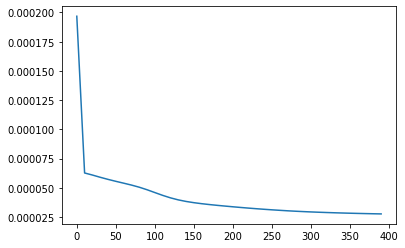

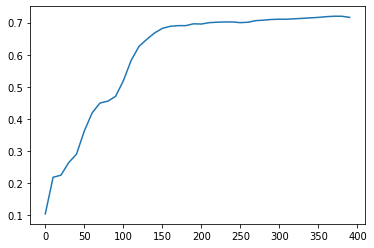

0.6866666666666666

In [18]:
run(trX,trainY,tX,testY,400,5,gd = True)

0.0001872662306990108
5.837220642316675e-05
5.507201882952607e-05
5.1858677332003484e-05
4.82396331006585e-05
4.7066671401693065e-05
4.285408506086276e-05
4.019477537088103e-05
3.8465624285340225e-05
3.6857609090884815e-05
3.601634815979181e-05
3.5207917662415955e-05
3.458511896554132e-05
3.370062293218025e-05
3.335934787602531e-05
3.2591289372794166e-05
3.089377126686055e-05
3.073724672421083e-05
2.9734632194717058e-05
2.9523779479338536e-05
2.9098546792417115e-05
2.8881475137918956e-05
2.8733665116278965e-05
2.8173726831904887e-05
2.7941928765398816e-05
2.7502848626556544e-05
2.733537796012755e-05
2.7061383910479494e-05
2.6895628565037743e-05
2.7638102864375518e-05
2.693422357044332e-05
2.652917591945534e-05
2.6188844538399728e-05
2.599022933408337e-05
2.5742605202227426e-05
2.575221540648652e-05
2.5497352109543833e-05
2.540726494830458e-05
2.530378162312351e-05
2.508313659314986e-05


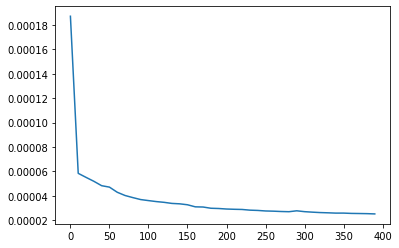

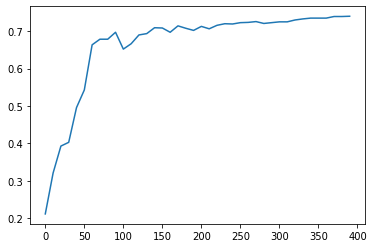

0.715

In [21]:
run(trX,trainY,tX,testY,400,10,gd = True)

0.13400014846890954
0.07883744826262955
0.06664890547536056
0.05762859691075078
0.0520425177501226
0.048270404749164705
0.04537169162464563
0.04313179311845807
0.04153345603581109
0.040416044327554794


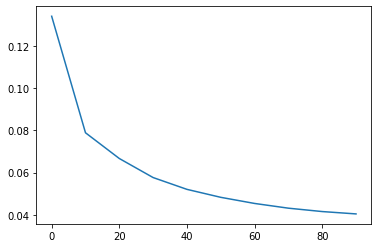

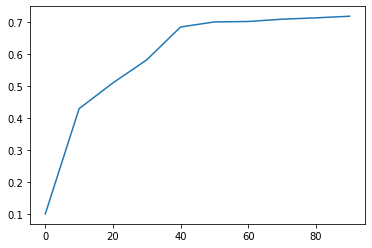

0.68

In [37]:
run(trX,trainY,tX,testY,100,0.01)

0.10090020167507177
0.07069314238092139
0.04857510776290267
0.040234429860914064
0.03828171283891578
0.0371606865040396
0.03622433836862658
0.035368678819403886
0.03460649882608863
0.03393034216383804


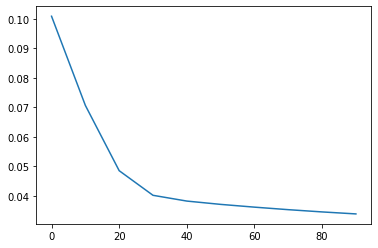

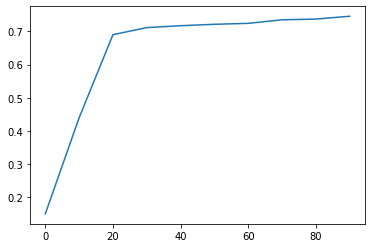

0.745

In [36]:
run(trX,trainY,tX,testY,100,0.05)

0.09013931153841197
0.04448908626067918
0.038870923503193586
0.037424284782276634
0.035959633582589766
0.033981743550010005
0.03282262814571056
0.032326833384244344
0.03200629589130697
0.031764878773041766


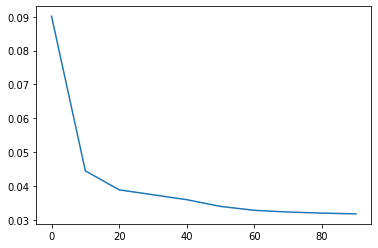

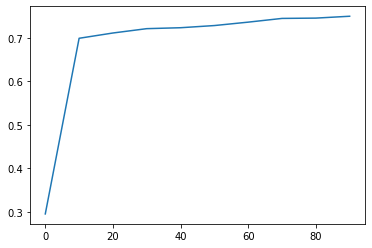

0.7516666666666667

In [24]:
run(trX,trainY,tX,testY,100,0.1)

In [25]:
def runsingle(trainX,trainY,testX,testY,epochs,lr,gd = False):
    layers = [
            NormalLayer(6,30),
            NormalLayer(30,10),
            ActivationLayer(sigmoid,sigmoid_prime),
            NormalLayer(10,10),
            ActivationLayer(sigmoid,sigmoid_prime),
            ActivationLayer(softmax,softmax_prime),
        ]
    modelact = Network() 
    modelact.layers = layers
    if gd:
        modelact.trainGD(trainX,trainY,lr,epochs)
    else :
        modelact.train(trainX,trainY,lr,epochs)
    plot(modelact,epochs,10)
    return modelact.accuracy(testX,testY)

0.21011728664868068
0.08596888477178276
0.08159328467592691
0.07721806481234524
0.07286970384030504
0.06817861012384052
0.06390465749373464
0.0606450660059695
0.058107149475393347
0.05597459726925888


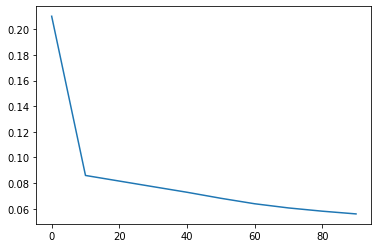

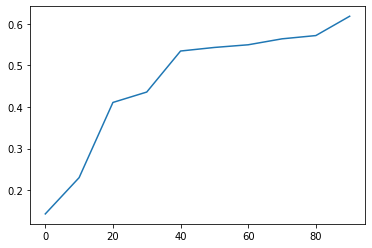

0.6383333333333333

In [38]:
runsingle(trX,trainY,tX,testY,100,0.01)

0.1078550904217328
0.0628106617140903
0.051898632931850756
0.045950911164491785
0.04291188409604102
0.04104878027204864
0.03977632161466216
0.038803641792150866
0.038014668059671075
0.03735844604839605


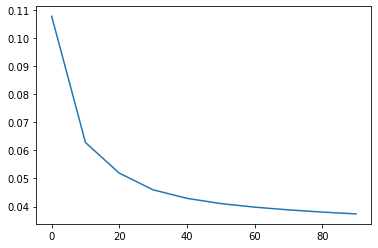

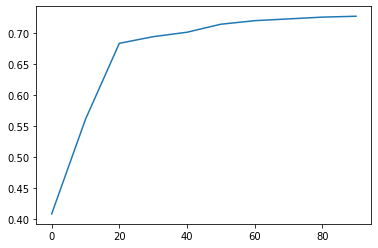

0.6983333333333334

In [39]:
runsingle(trX,trainY,tX,testY,100,0.05)

0.10785783721941525
0.05419005697090375
0.04606522019893379
0.042709804733955914
0.041070869561241646
0.03974921712780163
0.038576757241826604
0.03758075441084069
0.03670523967981442
0.03605093490755506


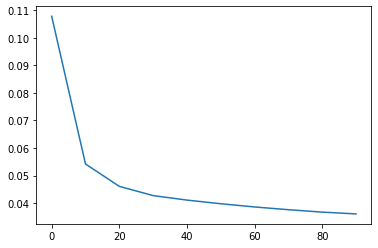

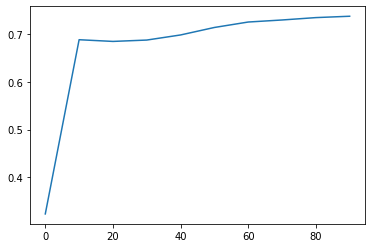

0.7116666666666667

In [40]:
runsingle(trX,trainY,tX,testY,100,0.1)